# Stage 1: LSTM + FP — LOS / NLOS Classification
## LSTM Baseline with FP_AMPL Conditioning

**Purpose**: LSTM with FP_AMPL1/2/3 conditioning — fair comparison against LNN+FP.

**FP Integration**: FP_AMPL1/2/3 → Linear(3→64) → 0.1·tanh → h₀/c₀ initialization.

| | LSTM+FP (this) | LSTM (CIR only) | LNN+FP | BERT+FP |
|---|---|---|---|---|
| Input | CIR + FP_AMPL | CIR only | CIR + FP_AMPL | CIR + FP_AMPL |
| FP usage | h₀/c₀ init | None | ODE h₀ init | Concat to CLS |

In [1]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "hidden_size": 64,
    "input_size": 1,
    "dropout": 0.2,
    "batch_size": 64,
    "max_epochs": 40,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "warmup_epochs": 3,
    "patience": 10,
    "grad_clip": 1.0,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "seed": 42,
}

In [2]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "c:\Users\preca\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\lib\curand64_10.dll" or one of its dependencies.

---
## Section 2: Data Loading, ROI Alignment & 70/15/15 Split

Same CIR preprocessing as all other models. **Now includes FP_AMPL1/2/3 extraction**.

In [ ]:
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


def load_cir_fp_dataset(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """Returns: X (N, 60, 1), y (N,), F (N, 3) — CIR + FP_AMPL features."""
    PRE = CONFIG["pre_crop"]
    TOTAL = CONFIG["total_len"]
    processed_seqs, labels, fp_features = [], [], []

    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    print(f"  Samples: {len(df)}, CIR columns: {len(cir_cols)}")

    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc

        f1 = float(row.get('FP_AMPL1', 0)) / max(rxpacc, 1) / 64.0
        f2 = float(row.get('FP_AMPL2', 0)) / max(rxpacc, 1) / 64.0
        f3 = float(row.get('FP_AMPL3', 0)) / max(rxpacc, 1) / 64.0
        fp_features.append([f1, f2, f3])

        leading_edge = get_roi_alignment(sig)
        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min, local_max = np.min(crop), np.max(crop)
        rng = local_max - local_min
        crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)

        processed_seqs.append(crop)
        labels.append(float(row['Label']))

    X = np.array(processed_seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)
    F = np.array(fp_features).astype(np.float32)
    print(f"  Output shape: X={X.shape}, y={y.shape}, F={F.shape}")
    print(f"  LOS: {int(np.sum(y == 0))}, NLOS: {int(np.sum(y == 1))}")
    return X, y, F


X_all, y_all, F_all = load_cir_fp_dataset("../dataset/channels/combined_uwb_dataset.csv")

indices = np.arange(len(y_all))
idx_train, idx_temp = train_test_split(
    indices, test_size=CONFIG["val_ratio"] + CONFIG["test_ratio"],
    stratify=y_all, random_state=CONFIG["seed"]
)
idx_val, idx_test = train_test_split(
    idx_temp, test_size=CONFIG["test_ratio"] / (CONFIG["val_ratio"] + CONFIG["test_ratio"]),
    stratify=y_all[idx_temp], random_state=CONFIG["seed"]
)

X_train, y_train, F_train = X_all[idx_train], y_all[idx_train], F_all[idx_train]
X_val,   y_val,   F_val   = X_all[idx_val],   y_all[idx_val],   F_all[idx_val]
X_test,  y_test,  F_test  = X_all[idx_test],  y_all[idx_test],  F_all[idx_test]

print(f"\nSplit (70/15/15):")
print(f"  Train: {X_train.shape[0]} (LOS: {int(np.sum(y_train==0))}, NLOS: {int(np.sum(y_train==1))})")
print(f"  Val:   {X_val.shape[0]} (LOS: {int(np.sum(y_val==0))}, NLOS: {int(np.sum(y_val==1))})")
print(f"  Test:  {X_test.shape[0]} (LOS: {int(np.sum(y_test==0))}, NLOS: {int(np.sum(y_test==1))})")

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Samples: 3600, CIR columns: 1016
  Output shape: X=(3600, 60, 1), y=(3600,), F=(3600, 3)
  LOS: 1800, NLOS: 1800

Split (70/15/15):
  Train: 2520 (LOS: 1260, NLOS: 1260)
  Val:   540 (LOS: 270, NLOS: 270)
  Test:  540 (LOS: 270, NLOS: 270)


---
## Section 3: LSTM + FP Model Architecture

```
FP_AMPL (3) → Linear(3→64) → tanh × 0.1 → h₀, c₀
CIR (60,1) → LSTM(h₀,c₀) → mean(h_all, dim=t) → 64-dim → Classifier
```

**Average pooling design**: No attention pooling — the classifier sees the time-averaged LSTM hidden trajectory `(1/T) Σ h(t)`. This matches the LNN's average pooling readout for a fair apples-to-apples comparison of LSTM gates vs ODE dynamics.

In [ ]:
class LSTM_FP_Classifier(nn.Module):
    """
    LSTM with FP_AMPL conditioning — average pooling design.

    No attention pooling — the classifier sees the time-averaged LSTM hidden
    trajectory mean(h_all, dim=1). This matches the LNN's average pooling
    readout for a fair apples-to-apples comparison.
    """
    def __init__(self, input_size=1, hidden_size=64, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.fp_to_h0 = nn.Linear(3, hidden_size)
        self.fp_to_c0 = nn.Linear(3, hidden_size)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, fp_features=None, return_dynamics=False):
        batch_size = x_seq.size(0)

        if fp_features is not None:
            h0 = 0.1 * torch.tanh(self.fp_to_h0(fp_features)).unsqueeze(0)
            c0 = 0.1 * torch.tanh(self.fp_to_c0(fp_features)).unsqueeze(0)
        else:
            h0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
            c0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)

        h_all, (h_n, c_n) = self.lstm(x_seq, (h0, c0))

        h_avg = h_all.mean(dim=1)   # (B, T, H) → (B, H) — time-averaged trajectory
        pred = self.classifier(h_avg)

        if return_dynamics:
            return pred, h_all
        return pred

    def embed(self, x_seq, fp_features=None):
        batch_size = x_seq.size(0)
        if fp_features is not None:
            h0 = 0.1 * torch.tanh(self.fp_to_h0(fp_features)).unsqueeze(0)
            c0 = 0.1 * torch.tanh(self.fp_to_c0(fp_features)).unsqueeze(0)
        else:
            h0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
            c0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        h_all, _ = self.lstm(x_seq, (h0, c0))
        return h_all.mean(dim=1)   # (B, H) — time-averaged trajectory


_m = LSTM_FP_Classifier(input_size=1, hidden_size=64)
_total = sum(p.numel() for p in _m.parameters())
print(f"LSTM_FP_Classifier parameter count: {_total:,}")
print(f"  LSTM(1->64):          {sum(p.numel() for p in _m.lstm.parameters()):,}")
print(f"  FP->h0:               {sum(p.numel() for p in _m.fp_to_h0.parameters()):,}")
print(f"  FP->c0:               {sum(p.numel() for p in _m.fp_to_c0.parameters()):,}")
print(f"  Classifier:           {sum(p.numel() for p in _m.classifier.parameters()):,}")
print(f"  Pooling:              average-over-time (no attention — time-averaged trajectory)")
print(f"  Embedding dim: {_m.hidden_size}")
print(f"\n  FP conditioning: Linear(3->64) x 2, scale=0.1*tanh")
del _m

---
## Section 4: Training Pipeline

Same training config as all other models: AdamW, cosine LR with warmup, early stopping.

In [ ]:
def train_model(X_train, y_train, X_val, y_val, F_train, F_val, config=CONFIG):
    print(f"Training on {len(X_train)} samples, validating on {len(X_val)}")
    print(f"  Input: CIR + FP_AMPL conditioning (F_train={F_train.shape})")

    X_tr = torch.tensor(X_train).to(device)
    y_tr = torch.tensor(y_train).unsqueeze(1).to(device)
    X_va = torch.tensor(X_val).to(device)
    y_va = torch.tensor(y_val).unsqueeze(1).to(device)
    F_tr = torch.tensor(F_train).to(device)
    F_va = torch.tensor(F_val).to(device)

    train_ds = TensorDataset(X_tr, y_tr, F_tr)
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

    model = LSTM_FP_Classifier(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        dropout=config["dropout"],
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    warmup_epochs = config["warmup_epochs"]
    total_epochs  = config["max_epochs"]

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return max(0.01, 0.5 * (1.0 + math.cos(math.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["max_epochs"]):
        model.train()
        train_loss_sum = 0
        train_correct, train_total = 0, 0

        for batch_x, batch_y, batch_f in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x, fp_features=batch_f)
            loss = criterion(pred, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
            optimizer.step()
            train_loss_sum += loss.item() * len(batch_x)
            train_correct  += ((pred > 0.5).float() == batch_y).sum().item()
            train_total    += len(batch_x)

        train_loss = train_loss_sum / train_total
        train_acc  = train_correct / train_total

        model.eval()
        with torch.no_grad():
            val_pred = model(X_va, fp_features=F_va)
            val_loss = criterion(val_pred, y_va)
            val_acc  = ((val_pred > 0.5).float() == y_va).float().mean().item()

        lr_now = optimizer.param_groups[0]["lr"]
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss.item())
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(lr_now)

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 5 == 0 or epoch == config["max_epochs"] - 1:
            print(f"  Ep {epoch:>3} | Loss: {train_loss:.4f} | Val Acc: {100*val_acc:.2f}% | Best: {100*best_val_acc:.2f}% | LR: {lr_now:.1e}")

        if patience_counter >= config["patience"]:
            print(f"  Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_model_state)
    print(f"\nBest Validation Accuracy: {100*best_val_acc:.2f}%")
    return model, (X_va, y_va, F_va), history


best_model, best_data, best_history = train_model(X_train, y_train, X_val, y_val, F_train, F_val)

Training on 2520 samples, validating on 540
  Input: CIR + FP_AMPL conditioning (F_train=(2520, 3))
  Ep   0 | Loss: 0.6936 | Val Acc: 50.00% | Best: 50.00% | LR: 3.3e-04
  Ep   5 | Loss: 0.5647 | Val Acc: 69.63% | Best: 73.33% | LR: 9.9e-04
  Ep  10 | Loss: 0.5392 | Val Acc: 74.44% | Best: 74.44% | LR: 9.1e-04
  Ep  15 | Loss: 0.4954 | Val Acc: 77.04% | Best: 77.04% | LR: 7.6e-04
  Ep  20 | Loss: 0.0051 | Val Acc: 100.00% | Best: 100.00% | LR: 5.6e-04
  Ep  25 | Loss: 0.0077 | Val Acc: 99.81% | Best: 100.00% | LR: 3.5e-04
  Early stopping at epoch 28

Best Validation Accuracy: 100.00%


---
## Section 5: Diagnostics

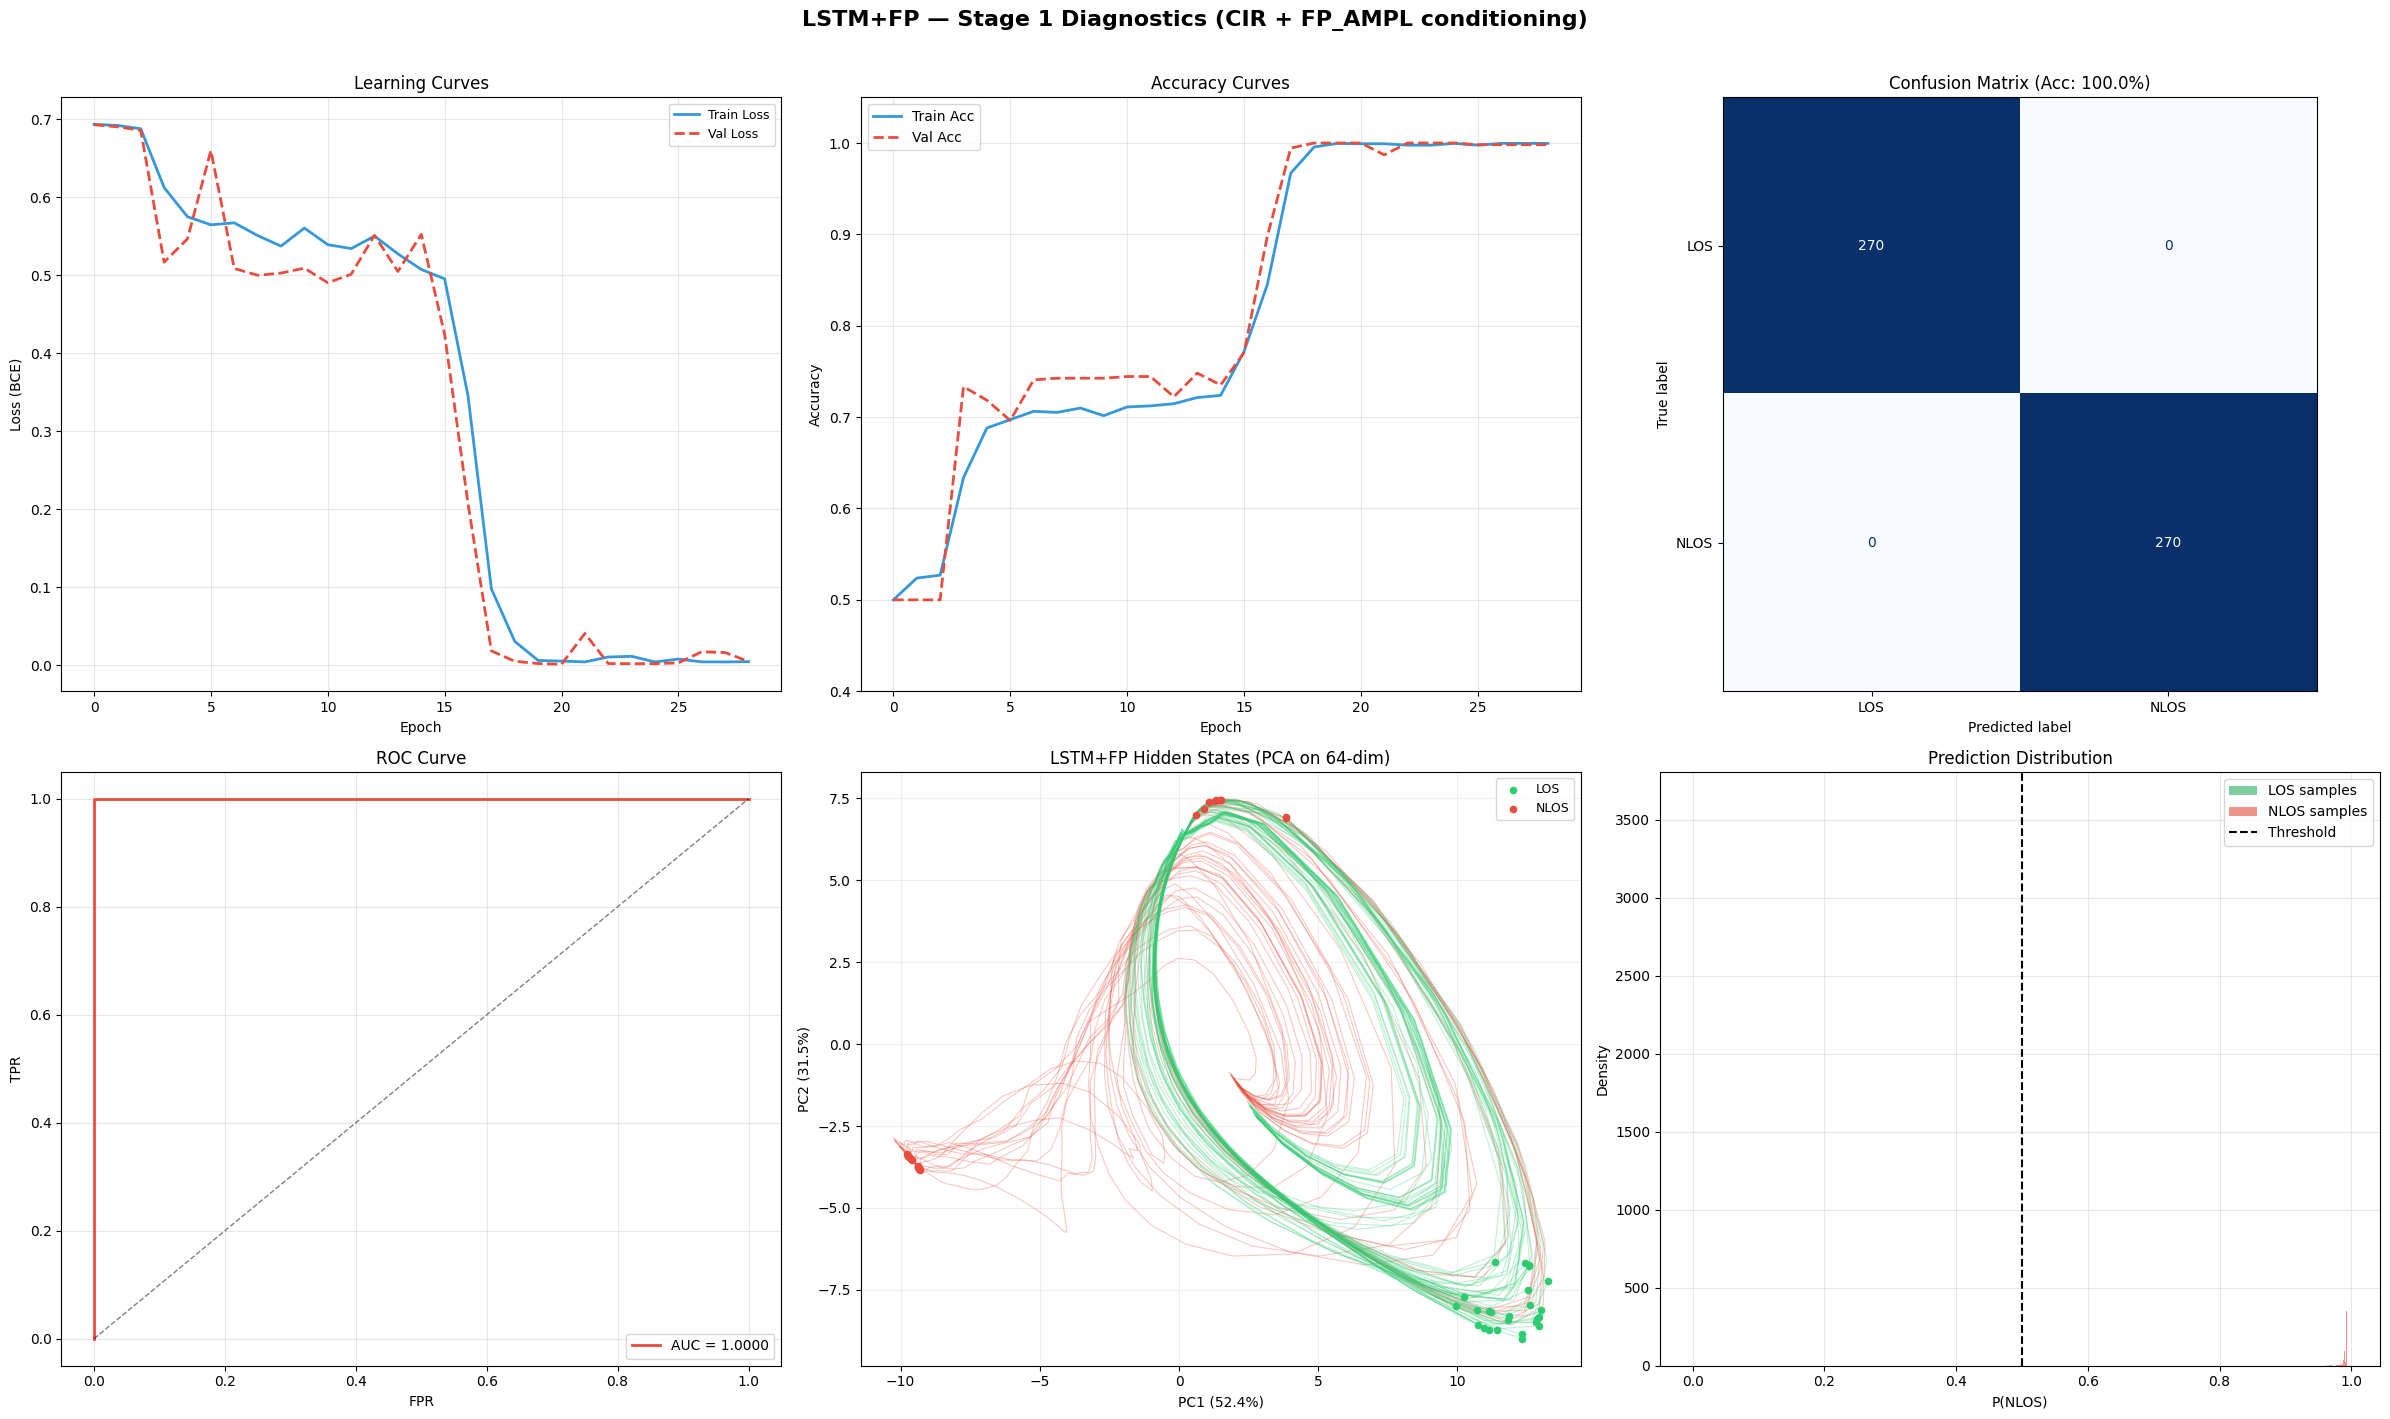

In [ ]:
def plot_diagnostics(model, val_data, history):
    X_va, y_va, F_va = val_data
    model.eval()
    with torch.no_grad():
        preds, h_all = model(X_va, fp_features=F_va, return_dynamics=True)

    y_true = y_va.cpu().numpy().flatten()
    y_prob = preds.cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(float)
    h_hist = h_all.cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(24, 14))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)

    ax = axs[0, 0]
    ax.plot(history["train_loss"], label="Train Loss", color="#3498db", lw=2)
    ax.plot(history["val_loss"],   label="Val Loss",   color="#e74c3c", lw=2, ls="--")
    ax.set_title("Learning Curves"); ax.set_xlabel("Epoch"); ax.set_ylabel("Loss (BCE)")
    ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

    ax = axs[0, 1]
    ax.plot(history["train_acc"], label="Train Acc", color="#3498db", lw=2)
    ax.plot(history["val_acc"],   label="Val Acc",   color="#e74c3c", lw=2, ls="--")
    ax.set_title("Accuracy Curves"); ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.set_ylim([0.4, 1.05]); ax.legend(); ax.grid(True, alpha=0.3)

    ax = axs[0, 2]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    acc = (y_true == y_pred).mean()
    ax.set_title(f"Confusion Matrix (Acc: {100*acc:.1f}%)")

    ax = axs[1, 0]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color="#e74c3c", lw=2, label=f"AUC = {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
    ax.set_title("ROC Curve"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.legend(loc="lower right"); ax.grid(True, alpha=0.3)

    ax = axs[1, 1]
    batch_size, seq_len, h = h_hist.shape
    los_idx  = np.where(y_true == 0)[0]
    nlos_idx = np.where(y_true == 1)[0]
    n_show   = min(len(los_idx), len(nlos_idx), 25)
    show_idx = np.concatenate([los_idx[:n_show], nlos_idx[:n_show]])
    h_flat = h_hist.reshape(-1, h)
    scaler = StandardScaler()
    h_flat_scaled = scaler.fit_transform(h_flat)
    pca = PCA(n_components=2)
    h_pca = pca.fit_transform(h_flat_scaled).reshape(batch_size, seq_len, 2)
    for i in [j for j in show_idx if y_true[j] == 1]:
        ax.plot(h_pca[i, :, 0], h_pca[i, :, 1], color="#e74c3c", alpha=0.3, lw=0.8)
        ax.scatter(h_pca[i, -1, 0], h_pca[i, -1, 1], color="#e74c3c", s=20, zorder=5)
    for i in [j for j in show_idx if y_true[j] == 0]:
        ax.plot(h_pca[i, :, 0], h_pca[i, :, 1], color="#2ecc71", alpha=0.3, lw=0.8)
        ax.scatter(h_pca[i, -1, 0], h_pca[i, -1, 1], color="#2ecc71", s=20, zorder=5)
    ax.scatter([], [], color="#2ecc71", s=20, label="LOS")
    ax.scatter([], [], color="#e74c3c", s=20, label="NLOS")
    ax.legend(fontsize=9)
    ax.set_title(f"LSTM+FP Hidden States (PCA on {h}-dim)")
    ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)")
    ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)")
    ax.grid(True, alpha=0.2)

    ax = axs[1, 2]
    ax.hist(y_prob[y_true == 0], bins=30, alpha=0.6, color="#27ae60", label="LOS samples", density=True)
    ax.hist(y_prob[y_true == 1], bins=30, alpha=0.6, color="#e74c3c", label="NLOS samples", density=True)
    ax.axvline(0.5, color="black", ls="--", lw=1.5, label="Threshold")
    ax.set_title("Prediction Distribution"); ax.set_xlabel("P(NLOS)"); ax.set_ylabel("Density")
    ax.legend(); ax.grid(True, alpha=0.3)

    plt.suptitle("LSTM+FP — Stage 1 Diagnostics (CIR + FP_AMPL conditioning)",
                 fontsize=16, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()


plot_diagnostics(best_model, best_data, best_history)

---
## Section 6: LSTM Hidden State Temporal Evolution

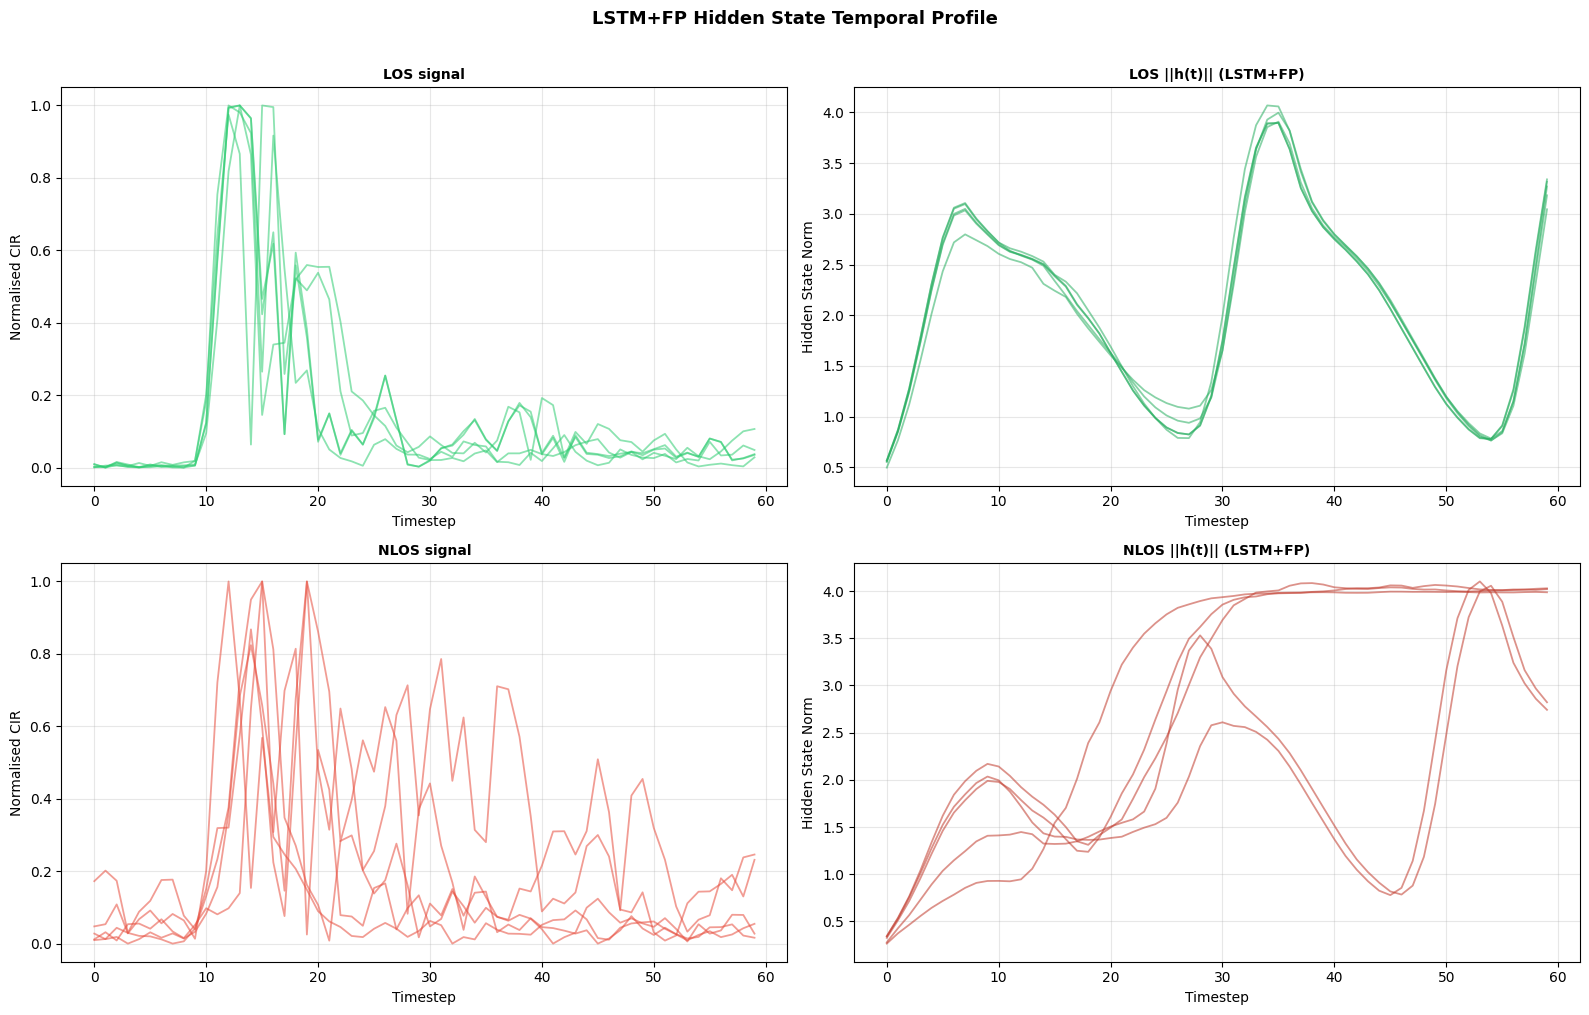

In [ ]:
def plot_hidden_temporal(model, val_data, n_samples=5):
    X_va, y_va, F_va = val_data
    model.eval()
    with torch.no_grad():
        _, h_all = model(X_va, fp_features=F_va, return_dynamics=True)
    y_true = y_va.cpu().numpy().flatten()
    h_norm = torch.norm(h_all, dim=2).cpu().numpy()
    x_input = X_va.cpu().numpy().squeeze(-1)
    los_idx  = np.where(y_true == 0)[0][:n_samples]
    nlos_idx = np.where(y_true == 1)[0][:n_samples]

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    titles = [
        ("LOS signal", los_idx, "#2ecc71", x_input),
        ("LOS ||h(t)|| (LSTM+FP)", los_idx, "#27ae60", h_norm),
        ("NLOS signal", nlos_idx, "#e74c3c", x_input),
        ("NLOS ||h(t)|| (LSTM+FP)", nlos_idx, "#c0392b", h_norm),
    ]
    for ax, (title, idx, color, data) in zip(axs.flat, titles):
        for i in idx:
            ax.plot(data[i], alpha=0.55, color=color, lw=1.3)
        ax.set_title(title, fontsize=10, fontweight="bold")
        ax.set_xlabel("Timestep"); ax.grid(True, alpha=0.3)
        ax.set_ylabel("Normalised CIR" if "signal" in title else "Hidden State Norm")
    plt.suptitle("LSTM+FP Hidden State Temporal Profile", fontsize=13, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

plot_hidden_temporal(best_model, best_data, n_samples=5)

---
## Section 7: Test Set Evaluation & Save Artifacts

Test Accuracy: 99.81%
Test AUC:      0.9973

Classification Report:
              precision    recall  f1-score   support

         LOS       1.00      1.00      1.00       270
        NLOS       1.00      1.00      1.00       270

    accuracy                           1.00       540
   macro avg       1.00      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540



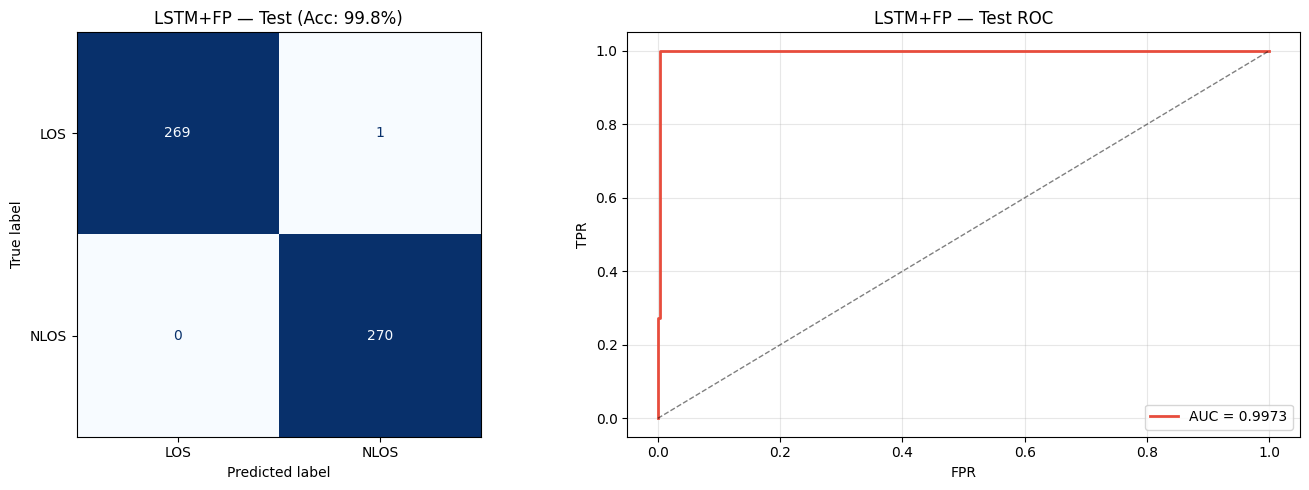


Model: LSTM_FP_Classifier | Embedding dim: 64 | Params: 19,777


In [ ]:
best_model.eval()
X_te = torch.tensor(X_test).to(device)
y_te = torch.tensor(y_test).unsqueeze(1).to(device)
F_te = torch.tensor(F_test).to(device)

with torch.no_grad():
    test_pred = best_model(X_te, fp_features=F_te)
    test_prob = test_pred.cpu().numpy().flatten()
    test_acc  = ((test_pred > 0.5).float() == y_te).float().mean().item()
    test_pred_np = (test_prob > 0.5).astype(float)
    test_true_np = y_test.flatten()

fpr, tpr, _ = roc_curve(test_true_np, test_prob)
test_auc = auc(fpr, tpr)

print(f"Test Accuracy: {100*test_acc:.2f}%")
print(f"Test AUC:      {test_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_true_np, test_pred_np, target_names=["LOS", "NLOS"]))

cm = confusion_matrix(test_true_np, test_pred_np)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axs[0], cmap="Blues", colorbar=False)
axs[0].set_title(f"LSTM+FP — Test (Acc: {100*test_acc:.1f}%)")
axs[1].plot(fpr, tpr, color="#e74c3c", lw=2, label=f"AUC = {test_auc:.4f}")
axs[1].plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
axs[1].set_title("LSTM+FP — Test ROC"); axs[1].set_xlabel("FPR"); axs[1].set_ylabel("TPR")
axs[1].legend(loc="lower right"); axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nModel: LSTM_FP_Classifier | Embedding dim: {best_model.hidden_size} | Params: {sum(p.numel() for p in best_model.parameters()):,}")

In [ ]:
torch.save(best_model.state_dict(), "stage1_lstm_fp_best.pt")
print("Saved: stage1_lstm_fp_best.pt")
torch.save({"config": CONFIG}, "stage1_lstm_fp_config.pt")
print("Saved: stage1_lstm_fp_config.pt")

Saved: stage1_lstm_fp_best.pt
Saved: stage1_lstm_fp_config.pt


In [ ]:
print("Stage 1 LSTM+FP complete.")
print("Compare with: LSTM (CIR only), LNN+FP, BERT+FP")

Stage 1 LSTM+FP complete.
Compare with: LSTM (CIR only), LNN+FP, BERT+FP
